In [ ]:
# Connect to Drive and imports
from pathlib import Path
from google.colab import drive
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_prefix = 'Ott_dt002'
#Create a path to the exported folder
#Change path to match GoogleDrive location
path = Path('drive/My Drive/myExFolder')

[f for f in path.iterdir() if file_prefix in f.stem]

[PosixPath('drive/My Drive/myExFolder/Ott_dt002-mixer.json'),
 PosixPath('drive/My Drive/myExFolder/Ott_dt002-00000.tfrecord.gz')]

In [ ]:
import json

#loading the mixer json 
json_file = str(path/(file_prefix+'-mixer.json'))
json_text = !cat "{json_file}"

mixer = json.loads(json_text.nlstr)
mixer

{'patchDimensions': [100, 100],
 'patchesPerRow': 7,
 'projection': {'affine': {'doubleMatrix': [10.0,
    0.0,
    428030.0,
    0.0,
    -10.0,
    5026070.0]},
  'crs': 'EPSG:32618'},
 'totalPatches': 35}

In [ ]:
# Get info from the JSON mixer file.
patch_width = mixer['patchDimensions'][0]
patch_height = mixer['patchDimensions'][1]
patches = mixer['totalPatches']
patch_dimensions_flat = [patch_width, patch_height]

In [ ]:
#Bands of interest 
bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'ndwi', 'ndvi']

#transform to list of image values
image_columns = [
  tf.io.FixedLenFeature(shape=patch_dimensions_flat, dtype=tf.float32) 
    for k in bands]

bands += ['classes']
image_columns += [tf.io.FixedLenFeature(shape=patch_dimensions_flat, dtype=tf.int64)]

# Parsing dictionary.
image_features_dict = dict(zip(bands, image_columns))
image_features_dict

{'B1': FixedLenFeature(shape=[100, 100], dtype=tf.float32, default_value=None),
 'B11': FixedLenFeature(shape=[100, 100], dtype=tf.float32, default_value=None),
 'B12': FixedLenFeature(shape=[100, 100], dtype=tf.float32, default_value=None),
 'B2': FixedLenFeature(shape=[100, 100], dtype=tf.float32, default_value=None),
 'B3': FixedLenFeature(shape=[100, 100], dtype=tf.float32, default_value=None),
 'B4': FixedLenFeature(shape=[100, 100], dtype=tf.float32, default_value=None),
 'B5': FixedLenFeature(shape=[100, 100], dtype=tf.float32, default_value=None),
 'B6': FixedLenFeature(shape=[100, 100], dtype=tf.float32, default_value=None),
 'B7': FixedLenFeature(shape=[100, 100], dtype=tf.float32, default_value=None),
 'B8': FixedLenFeature(shape=[100, 100], dtype=tf.float32, default_value=None),
 'B8A': FixedLenFeature(shape=[100, 100], dtype=tf.float32, default_value=None),
 'B9': FixedLenFeature(shape=[100, 100], dtype=tf.float32, default_value=None),
 'classes': FixedLenFeature(shape=[10

In [ ]:
# Parsing function.
def parse_image(example_proto):
  return tf.io.parse_single_example(example_proto, image_features_dict)

In [ ]:
#make dataset from files by specifying as list
image_dataset = tf.data.TFRecordDataset(str(path/(file_prefix+'-00000.tfrecord.gz')), compression_type='GZIP')
ds = image_dataset.map(parse_image, num_parallel_calls=5)
ds

<ParallelMapDataset shapes: {B1: (100, 100), B11: (100, 100), B12: (100, 100), B2: (100, 100), B3: (100, 100), B4: (100, 100), B5: (100, 100), B6: (100, 100), B7: (100, 100), B8: (100, 100), B8A: (100, 100), B9: (100, 100), classes: (100, 100), ndvi: (100, 100), ndwi: (100, 100)}, types: {B1: tf.float32, B11: tf.float32, B12: tf.float32, B2: tf.float32, B3: tf.float32, B4: tf.float32, B5: tf.float32, B6: tf.float32, B7: tf.float32, B8: tf.float32, B8A: tf.float32, B9: tf.float32, classes: tf.int64, ndvi: tf.float32, ndwi: tf.float32}>

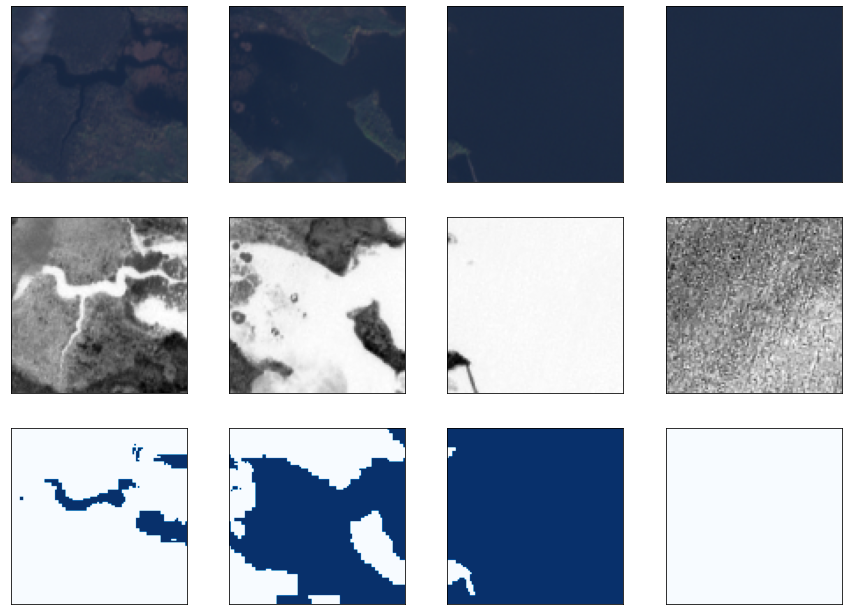

In [ ]:
#Loop through patches dataset. 
#Display example of exported patch/corrosponding mask
def plot_patch(ax, arr, cmap=None):
      ax.imshow(arr, cmap=cmap)
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

fig, ax = plt.subplots(3, 4, figsize=(15,11))

for i in range(4):
  img = list(ds.as_numpy_iterator())[i]
  rgb = np.concatenate((img['B4'][..., None], img['B3'][..., None], img['B2'][..., None]), axis=2)

  plot_patch(ax[0,i], rgb*3)
  plot_patch(ax[1,i], img['ndwi'], 'Greys_r')
  plot_patch(ax[2,i], img['classes'], 'Blues')